In [1]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
#gpuの確認
print(torch.cuda.is_available())

True


In [2]:
#学習済みの分散表現をロードする
from torchtext.vocab import Vectors

english_fasttext_vectors = Vectors(name='drive/My Drive/wiki-news-300d-1M.vec')

print(english_fasttext_vectors.dim)
print(len(english_fasttext_vectors.itos))

100%|█████████▉| 999801/999994 [01:36<00:00, 10535.77it/s]

300
999994


In [3]:
import string
import re

# 以下の記号はスペースに置き換えます（カンマ、ピリオドを除く）。
# punctuationとは日本語で句点という意味です
print("区切り文字：", string.punctuation)
# !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

# 前処理


def preprocessing_text(text):
    # 改行コードを消去
    text = re.sub('<br />', '', text)

    # カンマ、ピリオド以外の記号をスペースに置換
    for p in string.punctuation:
        if (p == ".") or (p == ","):
            continue
        else:
            text = text.replace(p, " ")

    # ピリオドなどの前後にはスペースを入れておく
    text = text.replace(".", " . ")
    text = text.replace(",", " , ")
    return text

# 分かち書き（今回はデータが英語で、簡易的にスペースで区切る）


def tokenizer_punctuation(text):
    return text.strip().split()


# 前処理と分かち書きをまとめた関数を定義
def tokenizer_with_preprocessing(text):
    text = preprocessing_text(text)
    ret = tokenizer_punctuation(text)
    return ret


# 動作を確認します
print(tokenizer_with_preprocessing('I like cats+'))

区切り文字： !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['I', 'like', 'cats']


In [4]:
import torchtext
from torchtext.data.utils import get_tokenizer

#テキストに処理を行うFieldを定義
#fix_lengthはtokenの数
TEXT = torchtext.data.Field(sequential=True, use_vocab=True, tokenize=tokenizer_with_preprocessing,
                            lower=True, include_lengths=True, batch_first=True, fix_length=40)

LABEL = torchtext.data.Field(sequential=False, use_vocab=False)

#pandasでcsvを保存するときに、labelをintでキャストしておかないとエラーでるから注意
train_ds, val_ds, test_ds = torchtext.data.TabularDataset.splits(
    path='drive/My Drive/dataset/CBET/ekman', train='train.csv', validation='val.csv', 
    test='test.csv', format='csv', fields=[('Text', TEXT), ('Label', LABEL)])

In [41]:
#ボキャブラリを作成する
TEXT.build_vocab(train_ds, vectors=english_fasttext_vectors)

print(len(TEXT.vocab.stoi))

batch_size = 64
d_model = 300
hidden_size = 512
output_dim = 5
dropout_rate = 0.5

51709


In [42]:
#データローダを作成
train_dl = torchtext.data.Iterator(train_ds, batch_size=batch_size, train=True)
val_dl = torchtext.data.Iterator(val_ds, batch_size=batch_size, train=False, sort=False)
test_dl = torchtext.data.Iterator(test_ds, batch_size=batch_size, train=False, sort=False)

#テスト
batch = next(iter(val_dl))
print(len(batch.Text[0][0]))
print(batch.Label)

40
tensor([4, 0, 2, 0, 2, 4, 4, 3, 1, 4, 2, 2, 1, 2, 2, 2, 1, 2, 3, 3, 0, 3, 4, 1,
        1, 3, 0, 2, 4, 1, 2, 2, 2, 3, 1, 2, 4, 3, 3, 4, 0, 0, 1, 3, 0, 3, 4, 0,
        0, 1, 2, 2, 1, 1, 4, 3, 2, 3, 3, 3, 2, 4, 4, 2])


In [43]:
class Embedder(nn.Module):
  def __init__(self, text_embedding_vectors, dropout_rate):
    super(Embedder, self).__init__()
    #tokenの数と、分散表現の次元数
    self.embeddings = nn.Embedding.from_pretrained(
        embeddings=text_embedding_vectors, freeze=True)
    self.dropout = nn.Dropout(dropout_rate)
  
  def forward(self, x):
    x = self.embeddings(x)
    x = self.dropout(x)
    return x


class LSTM_Layer(nn.Module):
  def __init__(self, d_model, hidden_size, dropout_rate):
    super().__init__()
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(d_model, hidden_size, batch_first=True, bidirectional=True)
    self.dropout = nn.Dropout(dropout_rate)

  #入力と(h, c)のタプル
  def forward(self, x):
    #[batch_size, ntoken, hidden_size*2], ([2, batch_size, hidden_size], [2, batch_size, hidden_size])
    output, (hn, cn) = self.lstm(x)
    output = torch.cat([hn[i, : ,:] for i in range(hn.shape[0])], dim=1) #[batch_size, hidden_size*2]
    output = self.dropout(output)
    return output, (hn, cn)

  
class ClassificationHead(nn.Module):
  def __init__(self, hidden_size, output_dim):
    super().__init__()
    self.linear = nn.Linear(hidden_size*2, output_dim)
    nn.init.normal_(self.linear.weight, std=0.02)
    nn.init.normal_(self.linear.bias, 0)

  def forward(self, x):
    output = self.linear(x)
    return output

class LSTM_Classification(nn.Module):
  def __init__(self, text_embedding_vectors, d_model, hidden_size, output_dim, dropout_rate):
    super().__init__()
    self.hidden_size = hidden_size
    self.net1 = Embedder(text_embedding_vectors, dropout_rate)
    self.net2 = LSTM_Layer(d_model, hidden_size, dropout_rate)
    self.net3 = ClassificationHead(hidden_size, output_dim)

  def forward(self, x):
    x1 = self.net1(x) # [batch_size, ntoken, d_model]
    x2, (ht, ct) = self.net2(x1) # [batch_size, ntoken, hidden_size], ([1, batch_size, hidden_size], [1, batch_size, hidden_size])
    #隠れ状態の最後を使う
    out = self.net3(x2) 
    return out

In [44]:
#テスト


batch = next(iter(train_dl))
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

# モデル構築
net = LSTM_Classification(TEXT.vocab.vectors, d_model, hidden_size, output_dim, dropout_rate) 
#hidden = net.init_hidden(device)

# 入出力
x = batch.Text[0]
x1 = net(x)

print("入力のテンソルサイズ：", x.shape)
print("出力のテンソルサイズ：", x1.shape)

入力のテンソルサイズ： torch.Size([64, 40])
出力のテンソルサイズ： torch.Size([64, 5])


In [45]:
dataloaders_dict = {'train': train_dl, 'val': val_dl}
criterion = nn.CrossEntropyLoss() 
net = LSTM_Classification(TEXT.vocab.vectors, d_model, hidden_size, output_dim, dropout_rate) 
net.train()

learning_rate = 10e-4
#optimizer = optim.SGD(net.parameters(), lr=learning_rate)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [46]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  net.to(device)

  torch.backends.cudnn.benchmark = True

  #各epoch
  for epoch in range(num_epochs):
    #訓練と評価
    for phase in ['train', 'val']:
      if phase == 'train':
        net.train()
      else:
        net.eval()
      
      epoch_loss = 0.0 #各epochの損失の和
      epoch_corrects = 0 #各epochの正解数

      for batch in (dataloaders_dict[phase]):
        inputs = batch.Text[0].to(device)
        labels = batch.Label.to(device)

        optimizer.zero_grad()
        
        with torch.set_grad_enabled(phase=='train'):
          #hidden = net.init_hidden(device) #LSTM隠れ状態の初期化
          outputs = net(inputs) #[batch_size, output_dim]

          loss = criterion(outputs, labels) #softmaxは中に入ってる
          _, preds = torch.max(outputs, 1)

          if phase == 'train':
            loss.backward() #勾配を計算
            optimizer.step() #パラメータを更新

          epoch_loss += loss.item()*inputs.size(0) #バッチ数をかけてあとでデータ量で割る
          epoch_corrects += torch.sum(preds == labels.data)
      
      #各epochのloss、正解数をだす
      epoch_loss = epoch_loss/len(dataloaders_dict[phase].dataset)
      epoch_acc = epoch_acc = epoch_corrects.double()/len(dataloaders_dict[phase].dataset)
      print('Epoch {}/{} | {:^5} |  Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,
                                                                     num_epochs, phase, epoch_loss, epoch_acc))
  return net

In [47]:
num_epochs = 10
net_trained = train_model(net, dataloaders_dict,
                          criterion, optimizer, num_epochs=num_epochs)
print({'次元数': d_model, '隠れ状態の次元数':hidden_size, 'クラス数': output_dim, 'ドロップアウト': dropout_rate, '学習率': learning_rate })

Epoch 1/10 | train |  Loss: 1.2838 Acc: 0.4623
Epoch 1/10 |  val  |  Loss: 1.0640 Acc: 0.5879
Epoch 2/10 | train |  Loss: 1.0862 Acc: 0.5716
Epoch 2/10 |  val  |  Loss: 1.0038 Acc: 0.6081
Epoch 3/10 | train |  Loss: 1.0368 Acc: 0.5925
Epoch 3/10 |  val  |  Loss: 0.9597 Acc: 0.6290
Epoch 4/10 | train |  Loss: 1.0052 Acc: 0.6068
Epoch 4/10 |  val  |  Loss: 0.9533 Acc: 0.6387
Epoch 5/10 | train |  Loss: 0.9790 Acc: 0.6170
Epoch 5/10 |  val  |  Loss: 0.9318 Acc: 0.6411
Epoch 6/10 | train |  Loss: 0.9536 Acc: 0.6283
Epoch 6/10 |  val  |  Loss: 0.9217 Acc: 0.6487
Epoch 7/10 | train |  Loss: 0.9349 Acc: 0.6353
Epoch 7/10 |  val  |  Loss: 0.9263 Acc: 0.6387
Epoch 8/10 | train |  Loss: 0.9105 Acc: 0.6460
Epoch 8/10 |  val  |  Loss: 0.9124 Acc: 0.6441
Epoch 9/10 | train |  Loss: 0.8891 Acc: 0.6559
Epoch 9/10 |  val  |  Loss: 0.8987 Acc: 0.6565
Epoch 10/10 | train |  Loss: 0.9367 Acc: 0.6472
Epoch 10/10 |  val  |  Loss: 0.9321 Acc: 0.6441
{'次元数': 300, '隠れ状態の次元数': 512, 'クラス数': 5, 'ドロップアウト': 0.5, '

In [48]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net_trained.eval()
net_trained.to(device)

y_true = np.array([])
y_pred = np.array([])

epoch_corrects = 0

for batch in (test_dl):
  inputs = batch.Text[0].to(device)
  labels = batch.Label.to(device)

  with torch.set_grad_enabled(False):
    outputs = net_trained(inputs)
    _, preds = torch.max(outputs, 1)
    
    y_true = np.concatenate([y_true, labels.to("cpu", torch.double).numpy()])
    y_pred = np.concatenate([y_pred, preds.to("cpu", torch.double).numpy()])

    epoch_corrects += torch.sum(preds == labels.data)

# 正解率
epoch_acc = epoch_corrects.double() / len(test_dl.dataset)

print('テストデータ{}個での正解率：{:.4f}'.format(len(test_dl.dataset),epoch_acc))

テストデータ4569個での正解率：0.6487


In [49]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.70      0.40      0.51       870
         1.0       0.79      0.72      0.76       900
         2.0       0.75      0.81      0.78      1063
         3.0       0.53      0.51      0.52       880
         4.0       0.52      0.77      0.62       856

    accuracy                           0.65      4569
   macro avg       0.66      0.64      0.64      4569
weighted avg       0.67      0.65      0.64      4569



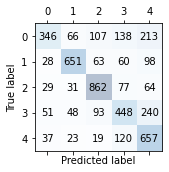

In [50]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

confmat = confusion_matrix(y_true=y_true, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('confusion_matrix.png', dpi=300)
plt.show()